# Constants

In [2]:
BORDER_REMOVAL_SIZE = .08  # Going to trim %4 of the sides
PATCH_WIDTH = 8  # Its recommended to pick patch size that can be a multiple of 8 because of the images usually a multiple of 8
PATCH_HEIGHT = PATCH_WIDTH
PERCENTAGE_OF_RANDOM_PATCHES = .20
PERCENTAGE_OF_RANDOM_PATCHES_NAME = int(PERCENTAGE_OF_RANDOM_PATCHES*100)
TEST_RANDOM_PATCH_PERCENTAGE = False



# Installs

In [3]:
%time
!pip install patchify
!pip install -U scikit-learn
!pip install swifter
!pip install seaborn
!pip install -U scikit-image
!pip install opencv-python

Wall time: 0 ns


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\C0rbin\Scripts\python.exe -m pip install --upgrade pip' command.


# Imports

In [4]:
%%time
import random
import os
import io
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.patches as mplpatches
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, mean_squared_log_error
from sklearn.metrics import r2_score, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage.io import imread
from scipy.interpolate import BSpline, make_interp_spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
import hashlib

import swifter

from patchify import patchify
from pathlib import Path


from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from skimage.util.shape import view_as_windows
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import skimage
import cv2
from skimage import color


random.seed(42)
rng = np.random.default_rng(seed=42)

Wall time: 10.9 s


# Story Arch

1. Read in the csv
2. Look at canidates
3. Compute the ITA values
4. Compute the catagory
5. Compute the metrics

# Read the CSV

In [5]:
df_csv_info = pd.read_csv("fitzpatrick17k.csv")

In [6]:
df_csv_info.head()

,Unnamed: 0,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,0,5e82a45bc5d78bd24ae9202d194423f8,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,1,fa2911a9b13b6f8af79cb700937cc14f,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,3,0a94359e7eaacd7178e06b2823777789,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,4,a39ec3b1f22c08a421fa20535e037bba,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


# Read the canidate images

In [7]:
data_list = [] # col 1 = file hash, col 2 filename, col 3, image
for file in Path(".").glob("data/finalfitz17k/*.jpg"):
    hash = hashlib.md5(open(file,'rb').read()).hexdigest()
    orig_image = open(file,"rb").read()
    data_list.append([hash, str(file), orig_image])

In [8]:
# now to create the dataframe
df = pd.DataFrame(data=data_list, columns=["hash","file_path", "image"])

In [9]:
df.head()

,hash,file_path,image
0,000491af8dd4d739de520e8a68be7134,data\finalfitz17k\000491af8dd4d739de520e8a68be...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1,0009d89a58dac26bb3c113744b7b4196,data\finalfitz17k\0009d89a58dac26bb3c113744b7b...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...
2,000b6317b3be6d504e212a50e4d5667f,data\finalfitz17k\000b6317b3be6d504e212a50e4d5...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
3,000e8dd5ee75dd6668e978e7a4e6fe54,data\finalfitz17k\000e8dd5ee75dd6668e978e7a4e6...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...
4,0012821d6f11b96cf33f2c2ee5c68d1f,data\finalfitz17k\0012821d6f11b96cf33f2c2ee5c6...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...


## Look at the shapes of the images.

In [40]:
shapes = {}
for item in df.iterrows():
    # print(item)
    orig_image = Image.open(io.BytesIO(item[1]["image"]))
    imgpx = np.array(orig_image)
    if str(imgpx.shape) in shapes:
        shapes[str(imgpx.shape)] += 1
    else:
        shapes[str(imgpx.shape)] = 1

In [ ]:
print(json.dumps(shapes, indent=4))

# Compute the ITA values

## Set up functions

In [10]:
def get_border_removal_size(image):
    """
    This function will compute the border removal size based on the width of the image as well as depending on the patch
    size to insure that the patches will covert the full image
    """
    w, h = image.size
    return int(math.ceil(w * BORDER_REMOVAL_SIZE / PATCH_WIDTH)) * PATCH_WIDTH

In [11]:
def trim_boarder_from_image(pil_image):
    """
    This function will take an image, remove the boarder and return the cropped image.
    """
    w, h = pil_image.size
    removal_size = get_border_removal_size(pil_image)
    cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
    cropped_image = pil_image.crop(cropped_area)
    return cropped_image

In [46]:
def format_image_and_get_patches(image):
    """
    This function will remove the 4% boarder, convert the whole image from RGB to LAB and then using Patchify
    tool it will create patches. These patches are non-overlapping that create a grid over the whole image.
    The image sizes are defined from the Constants section.
    """
    img = io.BytesIO(image)
    pil_image = Image.open(img)

    # Crop image to remove the pixels from the boarder
    w, h = pil_image.size
    removal_size = get_border_removal_size(pil_image)
    cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
    cropped_image = pil_image.crop(cropped_area)


    #print("pil_image", np.array(pil_image).shape)
    #print("cropped_image", np.array(cropped_image).shape)
    # Convert image to lab values

    lab = np.array(skimage.color.rgb2lab(cropped_image))

    # Get the patches
    return patchify(lab, (PATCH_WIDTH,PATCH_HEIGHT,3), step=PATCH_WIDTH)

In [13]:
def compute_ita_from_lab(lab):
    """
    This function computes the ITA value of the image along with ignore any pixels that are completly black
    """
    # get the luminance and b values wihtin +- 1 std from mean
    l = lab[:,:,0]
    l = np.where(l != 0, l, np.nan)
    std = np.nanstd(l)
    mean = np.nanmean(l)

    l = np.where(l >= mean - std, l, np.nan)
    l = np.where(l <= mean + std, l, np.nan)

    b = lab[:,:,2]
    std = np.nanstd(b)
    mean = np.nanmean(b)
    b = np.where(b >= mean - std, b, np.nan)
    b = np.where(b <= mean + std, b, np.nan)


    ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)
    return ita

In [47]:
def compute_ita(image, crop_border=False):
    """
    This function takes in an image and outputs the ITA value of image. To compute the ITA value the image needs
    to be converted from an RGB format to a LAB format type.

    There is an option to remove the boarder that is used to remove the back corners.
    """
    img = io.BytesIO(image)
    pilimae = Image.open(img)

    if crop_border:
        w, h = pilimae.size
        removal_size = get_border_removal_size(pilimae)
        cropped_area = (removal_size,removal_size,w - removal_size, h - removal_size)
        pilimae = pilimae.crop(cropped_area)


    try:
        lab = np.array(skimage.color.rgb2lab(pilimae))
    except:
        return -1000

    return compute_ita_from_lab(lab)

## Center Cropped

In [15]:
def get_cropped_center_patches_ita_list(image, verbose=False):
    """
    For the structure patches approach the first row, the last row, first column and last column will be
    sampled for the ITA values.
    """
    """
    Note we want to ignore the center part of the images. We will take 15% around the center of the image and ignore getting the ITA
    values for those images. Taking 15% of the width and height will get offset value. Then dividing the width and height by 2
    will be the mid-point which we can take the offset and do a +- to get a range where we dont want to capture the ITA values
    as long as the x and y indexes dont fall between both ranges then we will capture the ITA values of the image.

    """
    patches = format_image_and_get_patches(image)

    center_removal_percentage = .70/2
    h = len(patches)
    w = len(patches[0])

    w_offset = math.floor(w * center_removal_percentage)
    h_offset = math.floor(h * center_removal_percentage)

    w_mid = int(w/2)
    h_mid = int(h/2)

    indices = []

    if verbose:
        print("Will ignore values in these ranges")
        print("center_removal_percentage",center_removal_percentage)
        print("w",w)
        print("h",h)
        print("w_offset",w_offset)
        print("h_offset",h_offset)
        print("w_mid",w_mid)
        print("h_mid",h_mid)
        w_range = (w_mid + w_offset) - (w_mid - w_offset)
        print(f"w range diff {w_range} : % {w_range/w}")
        h_range = (h_mid + h_offset) - (h_mid - h_offset)
        print(f"h range diff {h_range} : %{h_range/h}")
        print(f"{w_mid - w_offset} <= x < {w_mid + w_offset} and {h_mid - h_offset} <= y < {h_mid + h_offset}")
    selected_ita_values = []
    for y, y_item in enumerate(patches):
        for x, x_item in enumerate(patches[y]):
            if w_mid - w_offset <= x < w_mid + w_offset and h_mid - h_offset <= y < h_mid + h_offset:
                continue
            patch = patches[y][x][0]
            selected_ita_values.append(compute_ita_from_lab(patch))
            indices.append([y,x])

    return selected_ita_values, indices

In [48]:
def get_cropped_center_ita(row):
    """
    This is the wrapper function to calculate the ITA values for all the patches, the median ITA value and
    stores all the patch indices for each Image of the dataset.
    """
    image = row["image"]
    try:
        ita_values, indices = get_cropped_center_patches_ita_list(image)
        # dropping any nan computed values
        ita_values = [x for x in ita_values if math.isnan(x) == False]
        row["ITA_center_cropped_all"] = ita_values
        row["ITA_center_cropped"] = np.median(ita_values)
        row["ITA_center_cropped_indices"] = indices
    except:
        row["ITA_center_cropped"] = -1000

    return row

## Structured Patches

In [17]:
def get_structured_patches_ita_list(image):
    """
    For the structure patches approach the first row, the last row, first column and last column will be
    sampled for the ITA values. When taking the boarder we need ot make sure the corners are not double counted
    """
    patches = format_image_and_get_patches(image)

    selected_ita_values = []

    row_count = len(patches)
    col_count = len(patches[0])


    indices = []
    # First row
    for i, patch in enumerate(patches[0]):
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([0,i])
    # last row
    for i, patch in enumerate(patches[-1]):
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([row_count - 1,i])
    # First column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][0]
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([i,0])

    # Last column
    # Not index zero and last index is a corner and already accounted for on the rows
    for i in range(1,row_count - 1):
        patch = patches[i][-1]
        selected_ita_values.append(compute_ita_from_lab(patch[0]))
        indices.append([i,col_count-1])


    return selected_ita_values, indices

In [49]:
def get_structured_patches_ita(row):
    """
    This function is intended to add the ITA represented value dataframe for an instance.
    Its intended to be used with the df.swifter.apply() method
    """
    image = row["image"]
    try:
        ita_values, indices = get_structured_patches_ita_list(image)
        # dropping any nan computed values
        ita_values = [x for x in ita_values if math.isnan(x) == False]
        row["ITA_structured_patches_all"] = ita_values
        row["ITA_structured_patches"] = np.median(ita_values)
        row["ITA_structured_patches_indices"] = indices
    except:
        row["ITA_structured_patches"] = -1000

    return row

## Random Patches

In [19]:
# randomly pick numbers between 0 and max patches
def get_random_patches_ita_list(image,percentage=PERCENTAGE_OF_RANDOM_PATCHES, verbose=False):
    """
    The premise behind random patches is that a set of patches that do not overlap a generated and at random patches
    be sampled to take the ITA value from. The thought would be that because its a random sample that the majority should
    cover or represent the skin tone. It is possible that some of the patches could cover a skin lesion which will be address in
    a future approach.
    """
    patches = format_image_and_get_patches(image)
    row_count = len(patches)
    column_count = len(patches[0])

    patch_count = row_count * column_count

    random_to_select = int(patch_count * percentage)

    # Generate a random list of numbers with no duplicates
    random_patch_indexes = rng.choice(patch_count, size=random_to_select, replace=False)
    random_patch_indexes.sort()

    # get reverse indexes. The index number comes from nRow * col_count + nCol.
    # so for example if you have 10x10 image. image index 23 is row 2 col 4. The formula would be 2*10 + 4 = 24
    # x = number % column_count
    # y = int(number / column_count)

    coordinate_indices = []
    for index in random_patch_indexes:
        y = index % column_count
        x = int(index /column_count)
        coordinate_indices.append([x,y])
    if verbose:
        print(f"row_count {row_count} column_count {column_count} ")
        print(f"patch_count {patch_count}, random_to_select {random_to_select}")
        #print(f"random_patch_indexes\n{random_patch_indexes}")
        #print(f"coordinate_indices\n{coordinate_indices}")

    ita_values = []
    for index in coordinate_indices:
        x = index[1]
        y = index[0]
        patch = patches[y][x]
        ita_values.append(compute_ita_from_lab(patch[0]))
    # dropping any nan computed values
    ita_values = [x for x in ita_values if math.isnan(x) == False]
    return ita_values, coordinate_indices

In [50]:
def get_random_patches_ita(row,percentage=PERCENTAGE_OF_RANDOM_PATCHES):
    """
    This function is intended to add the ITA represented value dataframe for an instance.
    Its intended to be used with the df.swifter.apply() method
    """

    image = row["image"]
    try:
        ita_values, indices = get_random_patches_ita_list(image, percentage)
        row[f"ITA_random_patches_{int(percentage*100)}_all"] = ita_values
        row[f"ITA_random_patches_{int(percentage*100)}"] = np.median(ita_values)
        row[f"ITA_random_patches_{int(percentage*100)}_indices"] = indices
    except:
        row[f"ITA_random_patches_{int(percentage*100)}"] = -1000
    return row

## Compute ITA values on whole image

In [31]:
%%time
df["ITA_orig"] = df["image"].apply(compute_ita,crop_border=True)

Wall time: 53min 49s


In [51]:
%%time
df = df.apply(get_cropped_center_ita, axis=1)

C:\Users\C0rbin\AppData\Local\Temp/ipykernel_19704/3321755401.py:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
C:\Users\C0rbin\AppData\Local\Temp/ipykernel_19704/3321755401.py:21: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


Wall time: 7h 12min 31s


In [53]:
%%time
df = df.apply(get_structured_patches_ita, axis=1)

C:\Users\C0rbin\AppData\Local\Temp/ipykernel_19704/3321755401.py:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
C:\Users\C0rbin\AppData\Local\Temp/ipykernel_19704/3321755401.py:21: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


Wall time: 1h 29min 59s


C:\Users\C0rbin\AppData\Local\Temp/ipykernel_19704/3321755401.py:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
C:\Users\C0rbin\AppData\Local\Temp/ipykernel_19704/3321755401.py:21: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


Wall time: 1h 28min 8s


In [54]:
%%time
df = df.apply(get_random_patches_ita, axis=1)

C:\Users\C0rbin\AppData\Local\Temp/ipykernel_19704/3321755401.py:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
C:\Users\C0rbin\AppData\Local\Temp/ipykernel_19704/3321755401.py:21: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


Wall time: 3h 10min 3s


In [55]:
df.head()

,ITA_center_cropped,ITA_center_cropped_all,ITA_center_cropped_indices,ITA_orig,ITA_orig_category,ITA_random_patches_20,ITA_random_patches_20_all,ITA_random_patches_20_indices,ITA_structured_patches,ITA_structured_patches_all,ITA_structured_patches_indices,file_path,hash,image
0,-86.319973,"[-95.49740514995437, -93.89204433188165, -88.1...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-89.912399,6,-91.105563,"[19.079669270628532, -91.07185302683192, -91.1...","[[0, 5], [0, 13], [0, 15], [0, 17], [0, 21], [...",-81.299635,"[-95.49740514995437, -93.89204433188165, -88.1...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000491af8dd4d739de520e8a68be...,000491af8dd4d739de520e8a68be7134,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1,-4.368209,"[69.14342626615937, 58.92391493893117, 54.9217...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",31.707877,3,22.730282,"[51.09764944131233, 48.00058569586861, 52.2334...","[[0, 3], [0, 5], [0, 7], [0, 16], [0, 17], [0,...",-27.032318,"[69.14342626615937, 58.92391493893117, 54.9217...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\0009d89a58dac26bb3c113744b7b...,0009d89a58dac26bb3c113744b7b4196,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...
2,63.902881,"[71.3777488793279, 78.36055446746393, 72.34238...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",63.160622,1,63.106361,"[77.42464881639646, 70.74856447644632, 70.0776...","[[0, 3], [0, 10], [0, 18], [0, 23], [0, 24], [...",64.165841,"[71.3777488793279, 78.36055446746393, 72.34238...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000b6317b3be6d504e212a50e4d5...,000b6317b3be6d504e212a50e4d5667f,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
3,-2.419620,"[-71.81196041228813, -74.074964659075, -43.006...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-17.835040,6,-19.772320,"[-33.166476726493194, -23.164401316590613, -2....","[[0, 3], [0, 4], [0, 8], [0, 12], [0, 22], [0,...",-3.292246,"[-71.81196041228813, -74.074964659075, -43.006...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000e8dd5ee75dd6668e978e7a4e6...,000e8dd5ee75dd6668e978e7a4e6fe54,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...
4,-17.580304,"[-82.36110662214149, -78.5225894924362, -69.97...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-21.982334,6,-6.519836,"[-14.653045358595628, -32.068731448543055, -35...","[[0, 6], [0, 13], [0, 15], [0, 18], [0, 20], [...",-5.237348,"[-82.36110662214149, -78.5225894924362, -69.97...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\0012821d6f11b96cf33f2c2ee5c6...,0012821d6f11b96cf33f2c2ee5c68d1f,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...


# Compute ITA category

In [56]:
def add_ita_6_category(ita):
    if ita <= 10:
        return "6"
    elif 10 < ita <= 19:
        return "5"
    elif 19 < ita <= 28:
        return "4"
    elif 28 < ita <= 41:
        return "3"
    elif 41 < ita <= 55:
        return "2"
    elif 55 < ita:
        return "1"
    else:
        print(f"None cat: {ita}")

In [57]:
%%time
print("orig")
df["ITA_orig_category"] = df["ITA_orig"].swifter.apply(add_ita_6_category)
print("center")
df["ITA_center_cropped_category"] = df["ITA_center_cropped"].swifter.apply(add_ita_6_category)
print("struct")
df["ITA_structured_patches_category"] = df["ITA_structured_patches"].swifter.apply(add_ita_6_category)
print("rand")
df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}_category"] = df[f"ITA_random_patches_{PERCENTAGE_OF_RANDOM_PATCHES_NAME}"].swifter.apply(add_ita_6_category)

orig


Pandas Apply:   0%|          | 0/16577 [00:00<?, ?it/s]

center


Pandas Apply:   0%|          | 0/16577 [00:00<?, ?it/s]

struct


Pandas Apply:   0%|          | 0/16577 [00:00<?, ?it/s]

rand


Pandas Apply:   0%|          | 0/16577 [00:00<?, ?it/s]

Wall time: 681 ms


In [58]:
catagories_to_test = ["ITA_orig", "ITA_center_cropped", "ITA_structured_patches", "ITA_random_patches_20"]
# convert to string type
for index, cat in enumerate(catagories_to_test):
    category = f"{cat}_category"
    df[category] = df[category].astype(str)

# Evaluate ITA

In [59]:
# df_mis_match = df[df.hash != Path(df.file_path).name.strip(".jpg")]
# df_mis_match

In [60]:
def add_label(row):
    """
    This function will look at the csv info and find the fitzpatrick label and apply it to the given row
    """
    hash = row["hash"]
    row["label"] = str(df_csv_info[df_csv_info["md5hash"] == hash]["fitzpatrick"].iloc[0])
    if row["label"] == "-1":
        print(hash)
    return row

In [61]:
%%time
# add the labels to the DF
df = df.apply(add_label, axis=1)

0041c7551e027def40cf81ab8fe14a36
011edfcd8849c12e56e89c8acbf546fe
016b658557ad43d6cc55ab2944e98e26
01799c46d7fa9c08d3353df0c67269d8
017ff9877a1eec742e799745d403f0a3
01be7f7454385c1abaa9d10aabcaa751
01fb028af4dce3dbf4730377aa797c4c
0274d0b67e1ed7079ea95b5dedb8a5f0
02ac06de46ddadc68923e8c1bc8854d1
02cc7827aab3924541e105df6e341d93
05e3894a471b152aa58389bfce9effc6
068ded0527f4d8d58915a7aa915df177
06927894daf158c5fafc52b5558dcc85
06cc4fb3cdb76cdfe4ef9a0ae2137108
086db5e7ff50e539718fa0b7715ef2c0
08904b2c711d4144603c07c8bf7bd5b7
09575dbf20e7ff6e4d722c720d423d45
0b04efa3c475de827500dad79ab23a37
0b0f2b4f378117d22eb167b8ef84f391
0b99557d47c568787ea3137fd3f28572
0c1d81533a06aa3086cf33b85ed77e16
0d4f2d1610e4a7ba1c56a832f4ac499c
0d88a95a70e08e9e5742a5a5c480c491
0dc2a0996ab1672b2ddd03fcf7435080
0dd4fb7e120caac9f1f7db96eae103f6
0dd88e8ca7395d947aa4f5946ef9b9b2
0dfca9fdbb4f07f16ca3914d30d729f8
0e46002c77a93390074906a00f3d075a
0e792dd9f58c7e674eb972176feb0202
0e7be7629b955ab8705877ba9c562302
0e9a7fe48b

In [62]:
image_hash = "000b6317b3be6d504e212a50e4d5667f"
df_csv_info[df_csv_info["md5hash"] == image_hash]["fitzpatrick"].iloc[0]

3

In [63]:
df.head()

,ITA_center_cropped,ITA_center_cropped_all,ITA_center_cropped_indices,ITA_orig,ITA_orig_category,ITA_random_patches_20,ITA_random_patches_20_all,ITA_random_patches_20_indices,ITA_structured_patches,ITA_structured_patches_all,ITA_structured_patches_indices,file_path,hash,image,ITA_center_cropped_category,ITA_structured_patches_category,ITA_random_patches_20_category,label
0,-86.319973,"[-95.49740514995437, -93.89204433188165, -88.1...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-89.912399,6,-91.105563,"[19.079669270628532, -91.07185302683192, -91.1...","[[0, 5], [0, 13], [0, 15], [0, 17], [0, 21], [...",-81.299635,"[-95.49740514995437, -93.89204433188165, -88.1...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000491af8dd4d739de520e8a68be...,000491af8dd4d739de520e8a68be7134,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,6,6,6,2
1,-4.368209,"[69.14342626615937, 58.92391493893117, 54.9217...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",31.707877,3,22.730282,"[51.09764944131233, 48.00058569586861, 52.2334...","[[0, 3], [0, 5], [0, 7], [0, 16], [0, 17], [0,...",-27.032318,"[69.14342626615937, 58.92391493893117, 54.9217...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\0009d89a58dac26bb3c113744b7b...,0009d89a58dac26bb3c113744b7b4196,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,6,6,4,3
2,63.902881,"[71.3777488793279, 78.36055446746393, 72.34238...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",63.160622,1,63.106361,"[77.42464881639646, 70.74856447644632, 70.0776...","[[0, 3], [0, 10], [0, 18], [0, 23], [0, 24], [...",64.165841,"[71.3777488793279, 78.36055446746393, 72.34238...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000b6317b3be6d504e212a50e4d5...,000b6317b3be6d504e212a50e4d5667f,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,1,1,1,3
3,-2.419620,"[-71.81196041228813, -74.074964659075, -43.006...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-17.835040,6,-19.772320,"[-33.166476726493194, -23.164401316590613, -2....","[[0, 3], [0, 4], [0, 8], [0, 12], [0, 22], [0,...",-3.292246,"[-71.81196041228813, -74.074964659075, -43.006...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000e8dd5ee75dd6668e978e7a4e6...,000e8dd5ee75dd6668e978e7a4e6fe54,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...,6,6,6,5
4,-17.580304,"[-82.36110662214149, -78.5225894924362, -69.97...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-21.982334,6,-6.519836,"[-14.653045358595628, -32.068731448543055, -35...","[[0, 6], [0, 13], [0, 15], [0, 18], [0, 20], [...",-5.237348,"[-82.36110662214149, -78.5225894924362, -69.97...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\0012821d6f11b96cf33f2c2ee5c6...,0012821d6f11b96cf33f2c2ee5c68d1f,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,6,6,6,3


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ITA_center_cropped               16577 non-null  float64
 1   ITA_center_cropped_all           16574 non-null  object 
 2   ITA_center_cropped_indices       16574 non-null  object 
 3   ITA_orig                         16577 non-null  float64
 4   ITA_orig_category                16577 non-null  object 
 5   ITA_random_patches_20            16577 non-null  float64
 6   ITA_random_patches_20_all        16574 non-null  object 
 7   ITA_random_patches_20_indices    16574 non-null  object 
 8   ITA_structured_patches           16577 non-null  float64
 9   ITA_structured_patches_all       16574 non-null  object 
 10  ITA_structured_patches_indices   16574 non-null  object 
 11  file_path                        16577 non-null  object 
 12  hash              

In [65]:
ITA_Categories_list = ["6", "5", "4", "3", "2", "1"]
ITA_Categories_list.reverse()

## View Distribution

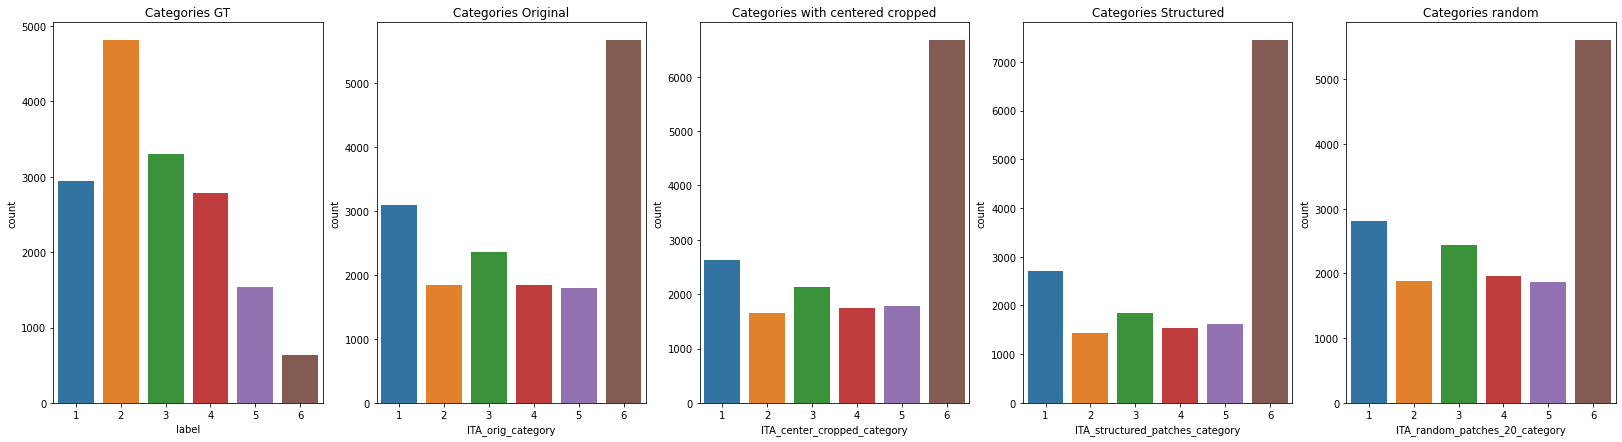

In [66]:
f, axes = plt.subplots(1, 5)
f.set_size_inches(28,7)

ax = sns.countplot(df.label,ax=axes[0],order=ITA_Categories_list).set_title("Categories GT")
ax = sns.countplot(df.ITA_orig_category,ax=axes[1],order=ITA_Categories_list).set_title("Categories Original")
ax = sns.countplot(df.ITA_center_cropped_category,ax=axes[2],order=ITA_Categories_list).set_title("Categories with centered cropped")
ax = sns.countplot(df.ITA_structured_patches_category,ax=axes[3],order=ITA_Categories_list).set_title("Categories Structured")
ax = sns.countplot(df.ITA_random_patches_20_category,ax=axes[4],order=ITA_Categories_list).set_title("Categories random")
# for i in range(0,5):
#     axes[i].set_yscale('log')

# Classification Performance

In [67]:
from sklearn import metrics
for index, cat in enumerate(catagories_to_test):

    category = f"{cat}_category"
    ground_truth = "label"

    #print(category, masked_cat)
    df_temp = df[df[category].notna()]
    df_temp = df_temp[df_temp[ground_truth].notna()]
    print(category)
    print(classification_report(df_temp[ground_truth],df_temp[category]))
    print("hamming_loss", hamming_loss(df_temp[ground_truth],df_temp[category]))
    print("---------------")

ITA_orig_category


c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       565
           1       0.46      0.48      0.47      2947
           2       0.43      0.17      0.24      4808
           3       0.29      0.21      0.24      3308
           4       0.22      0.15      0.18      2781
           5       0.10      0.11      0.10      1533
           6       0.09      0.79      0.16       635

    accuracy                           0.24     16577
   macro avg       0.23      0.27      0.20     16577
weighted avg       0.31      0.24      0.25     16577

hamming_loss 0.7600289557821077
---------------
ITA_center_cropped_category


c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       565
           1       0.46      0.41      0.43      2947
           2       0.44      0.15      0.23      4808
           3       0.28      0.18      0.22      3308
           4       0.20      0.13      0.15      2781
           5       0.07      0.09      0.08      1533
           6       0.07      0.78      0.14       635

    accuracy                           0.21     16577
   macro avg       0.22      0.25      0.18     16577
weighted avg       0.31      0.21      0.22     16577

hamming_loss 0.7890450624359052
---------------
ITA_structured_patches_category


c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       565
           1       0.40      0.37      0.38      2947
           2       0.43      0.13      0.20      4808
           3       0.27      0.15      0.19      3308
           4       0.20      0.11      0.14      2781
           5       0.08      0.09      0.08      1533
           6       0.06      0.72      0.11       635

    accuracy                           0.19     16577
   macro avg       0.21      0.22      0.16     16577
weighted avg       0.29      0.19      0.20     16577

hamming_loss 0.8134765035893105
---------------
ITA_random_patches_20_category


c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       565
           1       0.48      0.45      0.47      2947
           2       0.43      0.17      0.24      4808
           3       0.29      0.21      0.25      3308
           4       0.23      0.16      0.19      2781
           5       0.11      0.14      0.12      1533
           6       0.09      0.80      0.16       635

    accuracy                           0.24     16577
   macro avg       0.23      0.28      0.20     16577
weighted avg       0.32      0.24      0.25     16577

hamming_loss 0.7569524039331604
---------------


## View Confusion matrix

<Figure size 504x504 with 0 Axes>

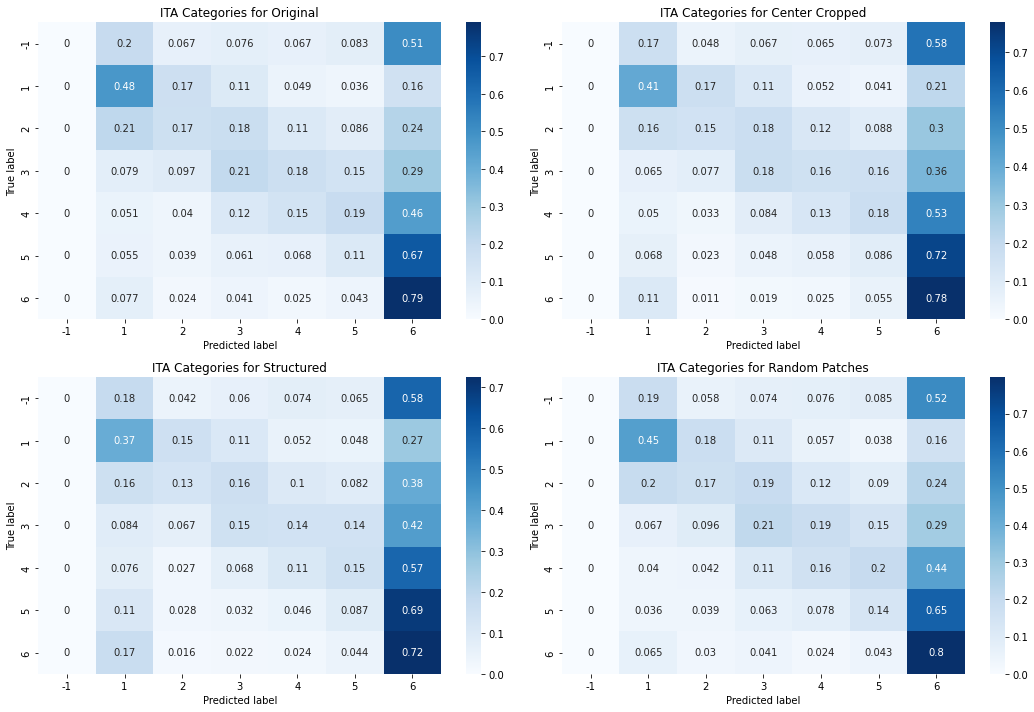

In [68]:
plt.figure(figsize=(7, 7))
cols = 2
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

plot_titles = ["ITA Categories for Original", "ITA Categories for Center Cropped", "ITA Categories for Structured", "ITA Categories for Random Patches",]

for index, cat in enumerate(catagories_to_test):

    category = f"{cat}_category"
    masked_cat = "label"

    #print(category, masked_cat)
    df_temp = df[df[category].notna()]
    df_temp = df_temp[df_temp[masked_cat].notna()]


    cm = confusion_matrix(df_temp[masked_cat],df_temp[category],normalize="true")
    df_cm = pd.DataFrame(cm,columns=np.unique(df_temp[masked_cat].to_numpy()),index=np.unique(df_temp[masked_cat].to_numpy()))
    row = index % cols
    col = int(index/cols)
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[col,row])
    ax.set_title(plot_titles[index])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
plt.tight_layout()

In [ ]:
# print out ones that are not the same
for index, cat in enumerate(catagories_to_test):
    category = f"{cat}_category"
    df_rez = df[df[category] != df.label]
    for index, row in df_rez.iterrows():

        if row[category] == '6' and  row.label == '2':
            #print(row.hash, row["file_path"])
            print(row.hash,row[category], row.label)
    break
    #print(df[category].unique())

# Experiment by creating makes

Create skin masks using [SkinDetection.py](https://github.com/CHEREF-Mehdi/SkinDetection/blob/master/SkinDetection.py)
where we will then use that to filter out any image that doesnt have a lot of skin showing.

In [70]:
df.head()

,ITA_center_cropped,ITA_center_cropped_all,ITA_center_cropped_indices,ITA_orig,ITA_orig_category,ITA_random_patches_20,ITA_random_patches_20_all,ITA_random_patches_20_indices,ITA_structured_patches,ITA_structured_patches_all,ITA_structured_patches_indices,file_path,hash,image,ITA_center_cropped_category,ITA_structured_patches_category,ITA_random_patches_20_category,label
0,-86.319973,"[-95.49740514995437, -93.89204433188165, -88.1...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-89.912399,6,-91.105563,"[19.079669270628532, -91.07185302683192, -91.1...","[[0, 5], [0, 13], [0, 15], [0, 17], [0, 21], [...",-81.299635,"[-95.49740514995437, -93.89204433188165, -88.1...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000491af8dd4d739de520e8a68be...,000491af8dd4d739de520e8a68be7134,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,6,6,6,2
1,-4.368209,"[69.14342626615937, 58.92391493893117, 54.9217...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",31.707877,3,22.730282,"[51.09764944131233, 48.00058569586861, 52.2334...","[[0, 3], [0, 5], [0, 7], [0, 16], [0, 17], [0,...",-27.032318,"[69.14342626615937, 58.92391493893117, 54.9217...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\0009d89a58dac26bb3c113744b7b...,0009d89a58dac26bb3c113744b7b4196,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,6,6,4,3
2,63.902881,"[71.3777488793279, 78.36055446746393, 72.34238...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",63.160622,1,63.106361,"[77.42464881639646, 70.74856447644632, 70.0776...","[[0, 3], [0, 10], [0, 18], [0, 23], [0, 24], [...",64.165841,"[71.3777488793279, 78.36055446746393, 72.34238...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000b6317b3be6d504e212a50e4d5...,000b6317b3be6d504e212a50e4d5667f,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,1,1,1,3
3,-2.419620,"[-71.81196041228813, -74.074964659075, -43.006...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-17.835040,6,-19.772320,"[-33.166476726493194, -23.164401316590613, -2....","[[0, 3], [0, 4], [0, 8], [0, 12], [0, 22], [0,...",-3.292246,"[-71.81196041228813, -74.074964659075, -43.006...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000e8dd5ee75dd6668e978e7a4e6...,000e8dd5ee75dd6668e978e7a4e6fe54,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...,6,6,6,5
4,-17.580304,"[-82.36110662214149, -78.5225894924362, -69.97...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-21.982334,6,-6.519836,"[-14.653045358595628, -32.068731448543055, -35...","[[0, 6], [0, 13], [0, 15], [0, 18], [0, 20], [...",-5.237348,"[-82.36110662214149, -78.5225894924362, -69.97...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\0012821d6f11b96cf33f2c2ee5c6...,0012821d6f11b96cf33f2c2ee5c68d1f,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,6,6,6,3


In [71]:
"""
Steps
1. Read image
2. Create HSV mask
3. Create YCrCb mask
4. Merge masks
5. Store global mask
6. Compute % skin of image
"""

def compute_skin_masks(row):
    img = cv2.imread(row.file_path)

    #converting from gbr to hsv color space
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #skin color range for hsv color space
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17, 170, 255))
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255, 180, 135))
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask = cv2.bitwise_and(YCrCb_mask, HSV_mask)
    global_mask = cv2.medianBlur(global_mask, 3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4, 4), np.uint8))

    global_result = cv2.bitwise_not(global_mask)

    mask_array = np.array(global_result)
    total = mask_array.size
    mask_count = np.count_nonzero(mask_array)
    percentage = mask_count / total
    row["skin_detection_percentage"] = math.ceil(percentage * 100)
    return row


In [72]:
df = df.apply(compute_skin_masks, axis=1)

In [73]:
df.head()

,ITA_center_cropped,ITA_center_cropped_all,ITA_center_cropped_indices,ITA_orig,ITA_orig_category,ITA_random_patches_20,ITA_random_patches_20_all,ITA_random_patches_20_indices,ITA_structured_patches,ITA_structured_patches_all,ITA_structured_patches_indices,file_path,hash,image,ITA_center_cropped_category,ITA_structured_patches_category,ITA_random_patches_20_category,label,skin_detection_percentage
0,-86.319973,"[-95.49740514995437, -93.89204433188165, -88.1...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-89.912399,6,-91.105563,"[19.079669270628532, -91.07185302683192, -91.1...","[[0, 5], [0, 13], [0, 15], [0, 17], [0, 21], [...",-81.299635,"[-95.49740514995437, -93.89204433188165, -88.1...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000491af8dd4d739de520e8a68be...,000491af8dd4d739de520e8a68be7134,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,6,6,6,2,88
1,-4.368209,"[69.14342626615937, 58.92391493893117, 54.9217...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",31.707877,3,22.730282,"[51.09764944131233, 48.00058569586861, 52.2334...","[[0, 3], [0, 5], [0, 7], [0, 16], [0, 17], [0,...",-27.032318,"[69.14342626615937, 58.92391493893117, 54.9217...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\0009d89a58dac26bb3c113744b7b...,0009d89a58dac26bb3c113744b7b4196,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,6,6,4,3,47
2,63.902881,"[71.3777488793279, 78.36055446746393, 72.34238...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",63.160622,1,63.106361,"[77.42464881639646, 70.74856447644632, 70.0776...","[[0, 3], [0, 10], [0, 18], [0, 23], [0, 24], [...",64.165841,"[71.3777488793279, 78.36055446746393, 72.34238...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000b6317b3be6d504e212a50e4d5...,000b6317b3be6d504e212a50e4d5667f,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,1,1,1,3,5
3,-2.419620,"[-71.81196041228813, -74.074964659075, -43.006...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-17.835040,6,-19.772320,"[-33.166476726493194, -23.164401316590613, -2....","[[0, 3], [0, 4], [0, 8], [0, 12], [0, 22], [0,...",-3.292246,"[-71.81196041228813, -74.074964659075, -43.006...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\000e8dd5ee75dd6668e978e7a4e6...,000e8dd5ee75dd6668e978e7a4e6fe54,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...,6,6,6,5,20
4,-17.580304,"[-82.36110662214149, -78.5225894924362, -69.97...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",-21.982334,6,-6.519836,"[-14.653045358595628, -32.068731448543055, -35...","[[0, 6], [0, 13], [0, 15], [0, 18], [0, 20], [...",-5.237348,"[-82.36110662214149, -78.5225894924362, -69.97...","[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",data\finalfitz17k\0012821d6f11b96cf33f2c2ee5c6...,0012821d6f11b96cf33f2c2ee5c68d1f,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,6,6,6,3,14


Text(0.5, 0, 'Skin percentage')

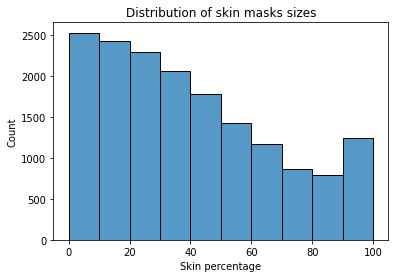

In [74]:
ax = sns.histplot(data=df.skin_detection_percentage, bins=10)
ax.set_title("Distribution of skin masks sizes")
ax.set_xlabel("Skin percentage")

## Filtered images
We will only look at images where the skin was detected 50%> and see how well the appraches worked for these images

In [75]:
df_filtered = df[df.skin_detection_percentage >= 70]

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ITA_center_cropped               16577 non-null  float64
 1   ITA_center_cropped_all           16574 non-null  object 
 2   ITA_center_cropped_indices       16574 non-null  object 
 3   ITA_orig                         16577 non-null  float64
 4   ITA_orig_category                16577 non-null  object 
 5   ITA_random_patches_20            16577 non-null  float64
 6   ITA_random_patches_20_all        16574 non-null  object 
 7   ITA_random_patches_20_indices    16574 non-null  object 
 8   ITA_structured_patches           16577 non-null  float64
 9   ITA_structured_patches_all       16574 non-null  object 
 10  ITA_structured_patches_indices   16574 non-null  object 
 11  file_path                        16577 non-null  object 
 12  hash              

In [77]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 16576
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ITA_center_cropped               2900 non-null   float64
 1   ITA_center_cropped_all           2897 non-null   object 
 2   ITA_center_cropped_indices       2897 non-null   object 
 3   ITA_orig                         2900 non-null   float64
 4   ITA_orig_category                2900 non-null   object 
 5   ITA_random_patches_20            2900 non-null   float64
 6   ITA_random_patches_20_all        2897 non-null   object 
 7   ITA_random_patches_20_indices    2897 non-null   object 
 8   ITA_structured_patches           2900 non-null   float64
 9   ITA_structured_patches_all       2897 non-null   object 
 10  ITA_structured_patches_indices   2897 non-null   object 
 11  file_path                        2900 non-null   object 
 12  hash               

## New Distribution

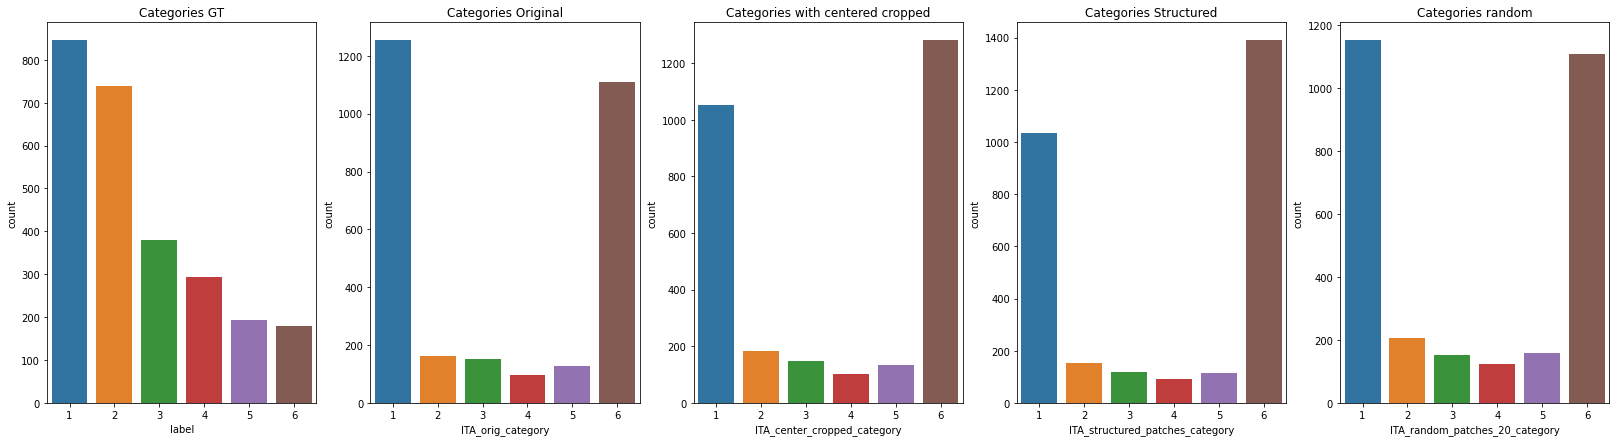

In [78]:
f, axes = plt.subplots(1, 5)
f.set_size_inches(28,7)

ax = sns.countplot(df_filtered.label,ax=axes[0],order=ITA_Categories_list).set_title("Categories GT")
ax = sns.countplot(df_filtered.ITA_orig_category,ax=axes[1],order=ITA_Categories_list).set_title("Categories Original")
ax = sns.countplot(df_filtered.ITA_center_cropped_category,ax=axes[2],order=ITA_Categories_list).set_title("Categories with centered cropped")
ax = sns.countplot(df_filtered.ITA_structured_patches_category,ax=axes[3],order=ITA_Categories_list).set_title("Categories Structured")
ax = sns.countplot(df_filtered.ITA_random_patches_20_category,ax=axes[4],order=ITA_Categories_list).set_title("Categories random")

In [79]:
from sklearn import metrics
for index, cat in enumerate(catagories_to_test):

    category = f"{cat}_category"
    ground_truth = "label"

    #print(category, masked_cat)
    df_temp = df_filtered[df_filtered[category].notna()]
    df_temp = df_temp[df_temp[ground_truth].notna()]
    print(category)
    print(classification_report(df_temp[ground_truth],df_temp[category]))
    print("hamming_loss", hamming_loss(df_temp[ground_truth],df_temp[category]))
    print("---------------")

ITA_orig_category
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       271
           1       0.45      0.67      0.54       845
           2       0.34      0.07      0.12       740
           3       0.18      0.07      0.11       379
           4       0.15      0.05      0.07       293
           5       0.04      0.03      0.03       193
           6       0.11      0.70      0.20       179

    accuracy                           0.27      2900
   macro avg       0.18      0.23      0.15      2900
weighted avg       0.27      0.27      0.22      2900

hamming_loss 0.7268965517241379
---------------
ITA_center_cropped_category


c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: Undefin

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       271
           1       0.45      0.56      0.50       845
           2       0.31      0.08      0.12       740
           3       0.21      0.08      0.12       379
           4       0.15      0.05      0.08       293
           5       0.09      0.06      0.07       193
           6       0.10      0.71      0.17       179

    accuracy                           0.25      2900
   macro avg       0.19      0.22      0.15      2900
weighted avg       0.26      0.25      0.22      2900

hamming_loss 0.7527586206896552
---------------
ITA_structured_patches_category
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       271
           1       0.42      0.51      0.46       845
           2       0.28      0.06      0.10       740
           3       0.19      0.06      0.09       379
           4       0.14      0.04      0.07       29

c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\c0rbin\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 504x504 with 0 Axes>

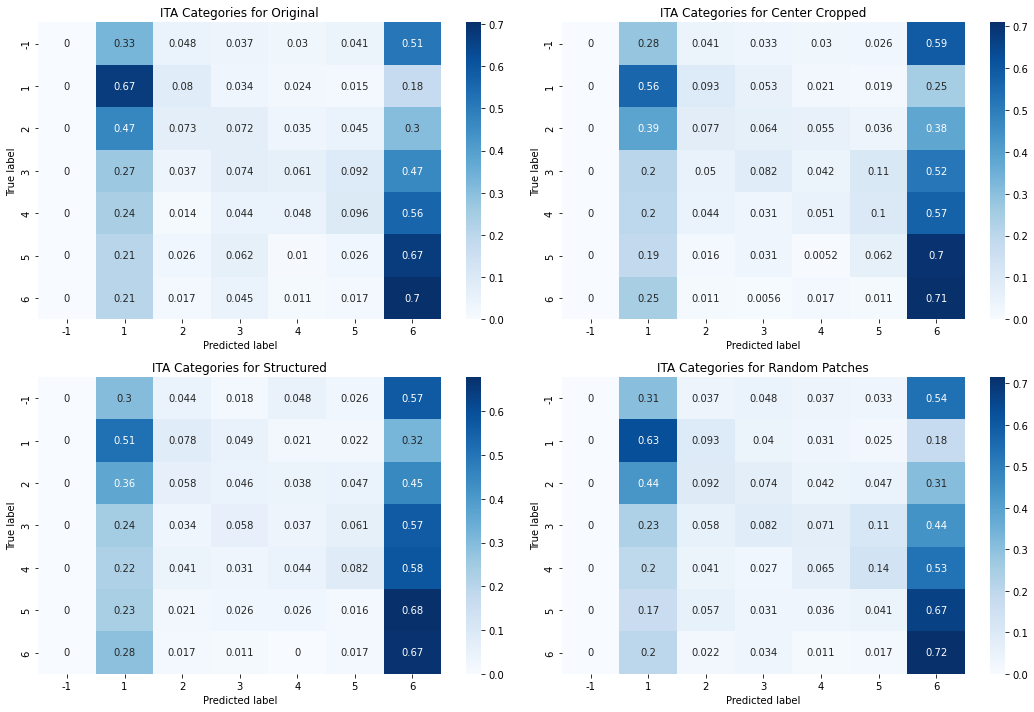

In [80]:
plt.figure(figsize=(7, 7))
cols = 2
rows = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

plot_titles = ["ITA Categories for Original", "ITA Categories for Center Cropped", "ITA Categories for Structured", "ITA Categories for Random Patches",]

for index, cat in enumerate(catagories_to_test):

    category = f"{cat}_category"
    masked_cat = "label"

    #print(category, masked_cat)
    df_temp = df_filtered[df_filtered[category].notna()]
    df_temp = df_temp[df_temp[masked_cat].notna()]


    cm = confusion_matrix(df_temp[masked_cat],df_temp[category],normalize="true")
    df_cm = pd.DataFrame(cm,columns=np.unique(df_temp[masked_cat].to_numpy()),index=np.unique(df_temp[masked_cat].to_numpy()))
    row = index % cols
    col = int(index/cols)
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues",ax=axes[col,row])
    ax.set_title(plot_titles[index])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
plt.tight_layout()